In [ ]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import pandas as pd
import tqdm 
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import pathlib
bs=64

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks/Datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
226md.png  5325m.png  7g3nf.png  ccf2w.png   f6ww8.png	myf82.png  pxdwp.png
22d5n.png  537nf.png  7gce6.png  ccn2x.png   f74x3.png	n265y.png  pxne8.png
2356g.png  53mn8.png  7gmf3.png  cd4eg.png   f753f.png	n2by7.png  pybee.png
23mdg.png  53wb8.png  7gnge.png  cd6p4.png   f75cx.png	n2c85.jpg  pyefb.png
23n88.png  53wp3.png  7gp47.png  cdcb3.png   f7cey.png	n2gmg.png  pyf65.png
243mm.png  556wd.png  7m8px.png  cdf77.png   f83pn.png	n336e.png  pym7p.png
244e2.png  55w5c.png  7mgmf.png  cdfen.png   f858x.png	n373n.png  w2e87.png
245y5.png  55y2m.png  7nnnx.png  cdmn8.png   f85y3.png	n3bm6.png  w2n7e.png
24f6w.png  56c34.png  7p852.png  cen55.png   f8f8g.png	n3ffn.png  w2yp7.png
24pew.png  56m6y.png  7pcd7.png  cewnm.png   fbp2c.png	n3m6x.png  w46ep.png
25257.png  56ncx.png  7pn5g.png  cfc2y.png   fc2ff.png	n3x4c.png  w48cw.png
253dc.png  573bn.png  7w67m.png  cf

In [ ]:
path_img = pathlib.PosixPath("/content/drive/My Drive/Colab Notebooks/Datasets/")
fnames = get_image_files(path_img)

In [ ]:
def encode_classes(fpath):
  name=fpath.name
  return ["0_"+name[0],"1_"+name[1],"2_"+name[2],"3_"+name[3],"4_"+name[4]]

In [ ]:
src= ImageList(fnames,path=path_img).split_by_rand_pct(0.2, seed=1111)

In [ ]:
bs=250
ds_tfms=get_transforms(do_flip=False,max_rotate=5)

In [ ]:
data = ImageDataBunch.create_from_ll(src.label_from_func(encode_classes),ds_tfms=ds_tfms,tfm_y=False,size=(48,192),bs=bs).normalize(imagenet_stats)

In [ ]:
model= models.resnet18(pretrained=True)

In [ ]:
from torchsummary import summary
summary(model.cuda(),input_size=(3,48,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 96]           9,408
       BatchNorm2d-2           [-1, 64, 24, 96]             128
              ReLU-3           [-1, 64, 24, 96]               0
         MaxPool2d-4           [-1, 64, 12, 48]               0
            Conv2d-5           [-1, 64, 12, 48]          36,864
       BatchNorm2d-6           [-1, 64, 12, 48]             128
              ReLU-7           [-1, 64, 12, 48]               0
            Conv2d-8           [-1, 64, 12, 48]          36,864
       BatchNorm2d-9           [-1, 64, 12, 48]             128
             ReLU-10           [-1, 64, 12, 48]               0
       BasicBlock-11           [-1, 64, 12, 48]               0
           Conv2d-12           [-1, 64, 12, 48]          36,864
      BatchNorm2d-13           [-1, 64, 12, 48]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.nn as nn

In [ ]:
num_cls=19+2
cols=12

In [ ]:
ctc_loss = nn.CTCLoss()
T = cols
C = num_cls
S = 7
S_min =5
padSymbol = 1

def ocr_ctc(input, target):
  N = input.shape[1]
  target_lengths = torch.full((N,), S_min, dtype=torch.int32).cpu()
  input_lengths = torch.full((N,), T, dtype=torch.int32).cpu()
  log_probs = input.cpu()
  targets = torch.full((N, S), padSymbol, dtype=torch.long)
  for i in range(5):
    start = i * 19
    end = (i + 1) * 19
    t = target[:, start:end]
    targets[:, i] = 2 + t.argmax(dim=-1).long()
  loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
  return loss

In [ ]:
class OCR(nn.Module):
  def __init__(self, *args):
    super(OCR, self).__init__()
    modelResnet18 = models.resnet18(pretrained=True)
    self.cnnModel = nn.Sequential(*list(modelResnet18.children())[:-3]) 
    self.adapter = nn.Sequential(nn.Dropout(0.2), nn.BatchNorm1d(num_features=256*3), nn.Linear(in_features=256*3, out_features=32))
    self.bi_gru = nn.GRU(input_size=32, hidden_size=512, bidirectional=True, dropout=0.1, num_layers=2, batch_first=True)
    self.finalAdapter = nn.Sequential(nn.Dropout(0.5), nn.BatchNorm1d(num_features=512*2), nn.Linear(in_features=1024, out_features=num_cls), nn.LogSoftmax(dim=1))

  def forward(self, x):
    x = self.cnnModel.forward(x) #self.cnnModel(x)
    x = x.view(-1, 256*3, cols)
    rnnInput = torch.zeros(x.shape[0], cols, 32).to(x.device)
    for i in range(cols):
      tmp = x[:, :, i]
      tmp = torch.reshape(tmp, (tmp.shape[0], 256*3))
      tmp = self.adapter.forward(tmp)
      rnnInput[:, i, :] = tmp
    
    (x, hn) = self.bi_gru(rnnInput)
    res = torch.zeros(cols, x.shape[0], num_cls).to(x.device)
    for i in range(cols):
      tmp = x[:, i, :]
      tmp = self.finalAdapter.forward(tmp)
      res[i, :, :] = tmp
    return res

In [ ]:
dataTest=(torch.zeros(120,3,48,192))
orcModel=OCR()
orcModel(dataTest).shape

torch.Size([12, 120, 21])

In [ ]:
########################
#                      #
#     learning         #
#                      #
########################

In [ ]:
learn = Learner(data, orcModel, layer_groups=[orcModel.cnnModel, orcModel.adapter, orcModel.bi_gru, orcModel.finalAdapter])
learn.loss_func = ocr_ctc

epoch,train_loss,valid_loss,time
0,5.477780,#na#,00:03
1,5.477870,#na#,00:03
2,5.481024,#na#,00:03
3,5.479822,#na#,00:03
4,5.480546,#na#,00:03
5,5.480099,#na#,00:03
6,5.480184,#na#,00:03
7,5.478763,#na#,00:03
8,5.477717,#na#,00:03
9,5.475634,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


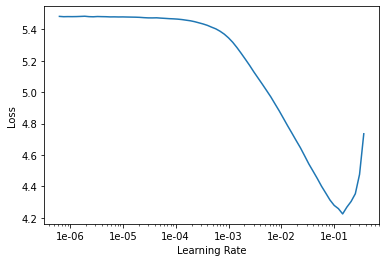

In [ ]:
learn.freeze_to(1)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.callbacks=[SaveModelCallback(learn),ShowGraph(learn)]
learn.metrics=[]

epoch,train_loss,valid_loss,time
0,5.155208,5.248373,00:04
1,4.702808,6.078539,00:04
2,4.508156,5.023615,00:04
3,4.339271,4.701698,00:04
4,4.153866,4.691857,00:04
5,4.032363,4.097191,00:04
6,3.937824,5.181118,00:04
7,3.840554,3.215504,00:04
8,3.730622,3.786894,00:04
9,3.606699,2.941393,00:04


Better model found at epoch 0 with valid_loss value: 5.248372554779053.


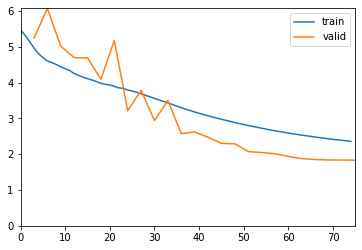

Better model found at epoch 2 with valid_loss value: 5.02361536026001.
Better model found at epoch 3 with valid_loss value: 4.701697826385498.
Better model found at epoch 4 with valid_loss value: 4.69185733795166.
Better model found at epoch 5 with valid_loss value: 4.097191333770752.
Better model found at epoch 7 with valid_loss value: 3.2155039310455322.
Better model found at epoch 9 with valid_loss value: 2.9413928985595703.
Better model found at epoch 11 with valid_loss value: 2.5762813091278076.
Better model found at epoch 13 with valid_loss value: 2.4754679203033447.
Better model found at epoch 14 with valid_loss value: 2.3042590618133545.
Better model found at epoch 15 with valid_loss value: 2.291506290435791.
Better model found at epoch 16 with valid_loss value: 2.075089454650879.
Better model found at epoch 17 with valid_loss value: 2.048947811126709.
Better model found at epoch 18 with valid_loss value: 2.012953996658325.
Better model found at epoch 19 with valid_loss value: 

In [ ]:
learn.fit_one_cycle(25,slice(1e-3, 1e-1))

In [ ]:
learn.save("stage1")
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,1.818628,#na#,00:03
1,1.824030,#na#,00:03
2,1.833041,#na#,00:03
3,1.835012,#na#,00:03
4,1.834965,#na#,00:03
5,1.836092,#na#,00:03
6,1.838636,#na#,00:03
7,1.835912,#na#,00:03
8,1.836425,#na#,00:03
9,1.833630,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


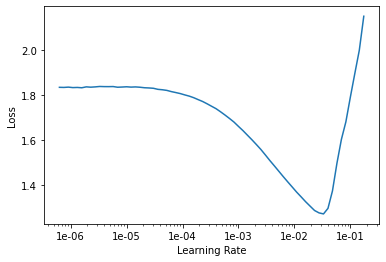

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,1.840357,1.851402,00:04
1,1.821312,1.823084,00:04
2,1.813735,1.803854,00:04
3,1.808665,1.805495,00:04
4,1.814986,1.809705,00:04
5,1.809494,1.807053,00:04
6,1.805388,1.790080,00:04
7,1.800421,1.789631,00:04
8,1.794436,1.772034,00:04
9,1.789186,1.745017,00:04


Better model found at epoch 0 with valid_loss value: 1.8514015674591064.


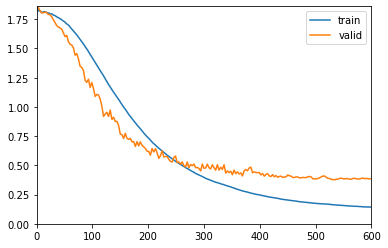

Better model found at epoch 1 with valid_loss value: 1.8230843544006348.
Better model found at epoch 2 with valid_loss value: 1.8038543462753296.
Better model found at epoch 6 with valid_loss value: 1.7900804281234741.
Better model found at epoch 7 with valid_loss value: 1.7896314859390259.
Better model found at epoch 8 with valid_loss value: 1.7720344066619873.
Better model found at epoch 9 with valid_loss value: 1.7450165748596191.
Better model found at epoch 10 with valid_loss value: 1.7231731414794922.
Better model found at epoch 11 with valid_loss value: 1.6953763961791992.
Better model found at epoch 12 with valid_loss value: 1.683549165725708.
Better model found at epoch 13 with valid_loss value: 1.6746349334716797.
Better model found at epoch 14 with valid_loss value: 1.665921688079834.
Better model found at epoch 15 with valid_loss value: 1.6334115266799927.
Better model found at epoch 16 with valid_loss value: 1.6009175777435303.
Better model found at epoch 18 with valid_loss

In [ ]:
learn.fit_one_cycle(200, max_lr=slice(1e-4, 5e-2))

In [ ]:
learn.save("stage1")
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.136266,#na#,00:03
1,0.145402,#na#,00:03
2,0.147249,#na#,00:03
3,0.146527,#na#,00:03
4,0.146291,#na#,00:03
5,0.147681,#na#,00:03
6,0.147744,#na#,00:03
7,0.145690,#na#,00:03
8,0.143767,#na#,00:03
9,0.143315,#na#,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


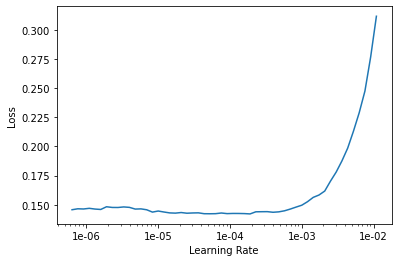

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.149596,0.407080,00:04
1,0.148519,0.421628,00:04
2,0.150120,0.421797,00:04
3,0.144407,0.404466,00:04
4,0.145302,0.400845,00:04
5,0.144343,0.419069,00:04
6,0.143192,0.431617,00:04
7,0.146035,0.438592,00:04
8,0.145757,0.449183,00:04
9,0.146224,0.438011,00:04


ERROR! Session/line number was not unique in database. History logging moved to new session 60
ERROR! Session/line number was not unique in database. History logging moved to new session 60
Better model found at epoch 0 with valid_loss value: 0.4070795178413391.


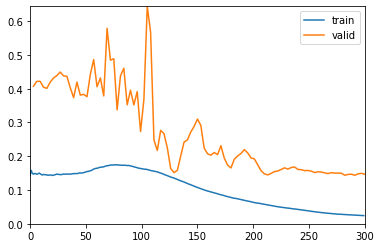

Better model found at epoch 3 with valid_loss value: 0.40446576476097107.
Better model found at epoch 4 with valid_loss value: 0.4008449614048004.
Better model found at epoch 12 with valid_loss value: 0.3734212815761566.
Better model found at epoch 25 with valid_loss value: 0.3371397852897644.
Better model found at epoch 32 with valid_loss value: 0.2730334401130676.
Better model found at epoch 36 with valid_loss value: 0.24788875877857208.
Better model found at epoch 37 with valid_loss value: 0.21706214547157288.
Better model found at epoch 41 with valid_loss value: 0.16345705091953278.
Better model found at epoch 42 with valid_loss value: 0.15142428874969482.
Better model found at epoch 69 with valid_loss value: 0.14783161878585815.
Better model found at epoch 70 with valid_loss value: 0.14473916590213776.
Better model found at epoch 93 with valid_loss value: 0.1436406821012497.


In [ ]:
learn.fit_one_cycle(100, max_lr=slice(1e-3, 1e-2))

In [ ]:
letters = ['<blank>',' ','2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
def get_str_ctc(list):
  prev=''
  str=''
  for c in list:
    if c==prev: continue
    if c==letters[0]:
      prev=''
      continue
    str+=c
    prev=c
  return str
print(get_str_ctc(['<blank>','b','b','5','5','p','n','<blank>','n','n','<blank>','<blank>','<blank>']))

b5pnn


In [ ]:
def decode_batch(out):
  ret=[]
  str=""
  prob=0
  for j in range(out.shape[0]):
    out_best=np.argmax(out[j, :], 1)

    outstr=''
    for c in out_best:
      outstr+=letters[c]
      prob+=out[j,0,c]
    ret.append(outstr)

  return(ret, get_str_ctc(ret),prob)

In [ ]:
#learn.load("bestmodel")
learn.save("bestmodel-3")

In [ ]:
from torchvision.transforms import *
tfms=(Normalize(*imagenet_stats))
#learn.load("bestmodel-2")
evalModel=learn.model.cpu().eval()

In [ ]:
wrong_idx = dict()
with torch.no_grad():
  validDs = data.valid_ds
  error = 0
  good = 0
  total = len(data.valid_ds.x)
  for idx in range(total):
    groundTrueStr = ""
    groundTrueStr=groundTrueStr.join(map(lambda s: s[2:], validDs.y[idx].obj))
    dataTest = validDs.x[idx]
    dataTest = dataTest.resize((3, 48, 192))
    imgData = torch.reshape( tfms(dataTest.data), (1, 3, 48, 192))

    predict = evalModel(imgData)
    (rawStr, predictStr, prob) = decode_batch(predict)

    if predictStr == groundTrueStr:
      good += 1
    else:
      error += 1
      #show_image(dataTest)
      wrong_idx[idx] = prob
      print(predictStr, groundTrueStr, predictStr==groundTrueStr, idx, prob)
print( total, 100.0 * good/total, 100.0 * error / total)

4d2m 4d22m False 10 tensor(-0.6767)
bwme bwmee False 34 tensor(-0.2963)
ncw7 ncww7 False 48 tensor(-0.3368)
yw67 yw667 False 60 tensor(-0.8601)
n36e n336e False 78 tensor(-0.8515)
x746 x7746 False 84 tensor(-0.4156)
y3nm y33nm False 85 tensor(-0.6019)
8gnnx 8gmnx False 98 tensor(-0.8340)
7nnx 7nnnx False 103 tensor(-1.0947)
7d4m 7d44m False 106 tensor(-0.2759)
ddcd ddcdd False 122 tensor(-0.0087)
f2bn f22bn False 124 tensor(-0.3821)
6n43 6n443 False 127 tensor(-0.3718)
wdw8 wdww8 False 145 tensor(-0.5273)
cg5d cg5dd False 158 tensor(-0.1293)
5mff 5mfff False 176 tensor(-0.5036)
cf2w ccf2w False 202 tensor(-0.0338)
213 92.01877934272301 7.981220657276995
